# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.338015
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.012388 analytic: -1.177082, relative error: 7.522117e-02
numerical: -2.778183 analytic: -3.155075, relative error: 6.352192e-02
numerical: 1.222982 analytic: 1.575310, relative error: 1.259084e-01
numerical: -0.780281 analytic: -0.879612, relative error: 5.984171e-02
numerical: -0.871895 analytic: -0.942830, relative error: 3.908869e-02
numerical: -0.037112 analytic: -0.028486, relative error: 1.314967e-01
numerical: 3.248475 analytic: 3.575178, relative error: 4.787807e-02
numerical: -1.301776 analytic: -1.704571, relative error: 1.339816e-01
numerical: -5.196390 analytic: -5.451036, relative error: 2.391623e-02
numerical: 0.015913 analytic: 0.282318, relative error: 8.932871e-01
numerical: -2.445097 analytic: -2.489472, relative error: 8.992645e-03
numerical: 0.480577 analytic: 0.907686, relative error: 3.076568e-01
numerical: 1.509058 analytic: 1.663194, relative error: 4.858878e-02
numerical: 1.387122 analytic: 1.648551, relative error: 8.611907e-02
numerical: 2.68612

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.338015e+00 computed in 0.228942s
vectorized loss: 2.338015e+00 computed in 0.037137s
Loss difference: 0.000000
Gradient difference: 36.089096


In [9]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rate = 1e-1
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
constant = 1
#for learning_rate in np.linspace(learning_rates[0],learning_rates[1],10):
for i in range(1,100):
    for regularization_strength in np.linspace(regularization_strengths[0], regularization_strengths[1], 10):
        softmax = Softmax()
        constant *= 0.9
        learning_rate *= constant 
        softmax.train(X_train, y_train, learning_rate,regularization_strength,1000,200,True)
        #predict y classes in X_train and X_val and find accuracies
        y_train_predict = softmax.predict(X_train)
        y_val_predict = softmax.predict(X_val)
        
        y_train_accu= np.mean(y_train_predict == y_train)
        y_val_accu = np.mean(y_val_predict == y_val)
        #save it's accuracies in the results dictionary.
        results[(learning_rate, regularization_strength)] = (y_train_accu, y_val_accu)
        if y_val_accu > best_val:
            best_val = y_val_accu
            best_softmax = softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1000: loss 774.514965


/Users/hyunwoojo/Desktop/spring1617_assignment1/assignment1/cs231n/classifiers/softmax.py:75: RuntimeWarning: overflow encountered in exp
  XW = np.exp(XW)
/Users/hyunwoojo/Desktop/spring1617_assignment1/assignment1/cs231n/classifiers/softmax.py:77: RuntimeWarning: invalid value encountered in true_divide
  XW /= np.reshape(np.sum(XW, axis = 1), (XW.shape[0],1) )
/Users/hyunwoojo/Desktop/spring1617_assignment1/assignment1/cs231n/classifiers/softmax.py:80: RuntimeWarning: divide by zero encountered in log
  y_scores = -np.log(y_scores)


iteration 100 / 1000: loss nan
iteration 200 / 1000: loss nan
iteration 300 / 1000: loss nan
iteration 400 / 1000: loss nan
iteration 500 / 1000: loss nan
iteration 600 / 1000: loss nan
iteration 700 / 1000: loss nan
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
iteration 0 / 1000: loss 860.130044
iteration 100 / 1000: loss nan
iteration 200 / 1000: loss nan
iteration 300 / 1000: loss nan
iteration 400 / 1000: loss nan
iteration 500 / 1000: loss nan
iteration 600 / 1000: loss nan
iteration 700 / 1000: loss nan
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
iteration 0 / 1000: loss 950.278763
iteration 100 / 1000: loss nan
iteration 200 / 1000: loss nan
iteration 300 / 1000: loss nan
iteration 400 / 1000: loss nan
iteration 500 / 1000: loss nan
iteration 600 / 1000: loss nan
iteration 700 / 1000: loss nan
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
iteration 0 / 1000: loss 1033.848973
iteration 100 / 1000: loss nan
iteration 200 / 1000: l

iteration 700 / 1000: loss 1040.490133
iteration 800 / 1000: loss 1040.144686
iteration 900 / 1000: loss 1040.287745
iteration 0 / 1000: loss 1125.276154
iteration 100 / 1000: loss 1125.576089
iteration 200 / 1000: loss 1125.719951
iteration 300 / 1000: loss 1125.487249
iteration 400 / 1000: loss 1125.738328
iteration 500 / 1000: loss 1125.695266
iteration 600 / 1000: loss 1125.238522
iteration 700 / 1000: loss 1125.392967
iteration 800 / 1000: loss 1125.541721
iteration 900 / 1000: loss 1125.767460
iteration 0 / 1000: loss 1211.801527
iteration 100 / 1000: loss 1211.740858
iteration 200 / 1000: loss 1211.492016
iteration 300 / 1000: loss 1211.875415
iteration 400 / 1000: loss 1211.275238
iteration 500 / 1000: loss 1211.385154
iteration 600 / 1000: loss 1211.773842
iteration 700 / 1000: loss 1211.072638
iteration 800 / 1000: loss 1211.745980
iteration 900 / 1000: loss 1211.951866
iteration 0 / 1000: loss 1286.092761
iteration 100 / 1000: loss 1285.725036
iteration 200 / 1000: loss 1285

iteration 0 / 1000: loss 1197.684203
iteration 100 / 1000: loss 1197.457108
iteration 200 / 1000: loss 1197.252540
iteration 300 / 1000: loss 1197.762955
iteration 400 / 1000: loss 1197.667745
iteration 500 / 1000: loss 1197.561715
iteration 600 / 1000: loss 1197.589065
iteration 700 / 1000: loss 1197.390716
iteration 800 / 1000: loss 1197.729961
iteration 900 / 1000: loss 1197.656782
iteration 0 / 1000: loss 1299.347288
iteration 100 / 1000: loss 1299.544143
iteration 200 / 1000: loss 1299.259691
iteration 300 / 1000: loss 1299.253988
iteration 400 / 1000: loss 1299.576157
iteration 500 / 1000: loss 1299.290776
iteration 600 / 1000: loss 1299.334253
iteration 700 / 1000: loss 1299.412766
iteration 800 / 1000: loss 1299.009626
iteration 900 / 1000: loss 1299.191081
iteration 0 / 1000: loss 1360.007900
iteration 100 / 1000: loss 1359.148526
iteration 200 / 1000: loss 1358.868392
iteration 300 / 1000: loss 1359.503677
iteration 400 / 1000: loss 1358.928539
iteration 500 / 1000: loss 1359

iteration 300 / 1000: loss 1282.850561
iteration 400 / 1000: loss 1282.613585
iteration 500 / 1000: loss 1282.715600
iteration 600 / 1000: loss 1282.765682
iteration 700 / 1000: loss 1283.466776
iteration 800 / 1000: loss 1282.845108
iteration 900 / 1000: loss 1282.885076
iteration 0 / 1000: loss 1364.356149
iteration 100 / 1000: loss 1364.189667
iteration 200 / 1000: loss 1364.598871
iteration 300 / 1000: loss 1364.469172
iteration 400 / 1000: loss 1364.436098
iteration 500 / 1000: loss 1364.484420
iteration 600 / 1000: loss 1364.336552
iteration 700 / 1000: loss 1364.732897
iteration 800 / 1000: loss 1364.810428
iteration 900 / 1000: loss 1364.853421
iteration 0 / 1000: loss 1452.978229
iteration 100 / 1000: loss 1453.304140
iteration 200 / 1000: loss 1453.142230
iteration 300 / 1000: loss 1453.136161
iteration 400 / 1000: loss 1452.995979
iteration 500 / 1000: loss 1453.311437
iteration 600 / 1000: loss 1453.030791
iteration 700 / 1000: loss 1452.989301
iteration 800 / 1000: loss 14

iteration 600 / 1000: loss 1379.005802
iteration 700 / 1000: loss 1378.590201
iteration 800 / 1000: loss 1378.432817
iteration 900 / 1000: loss 1379.032206
iteration 0 / 1000: loss 1441.533329
iteration 100 / 1000: loss 1440.739753
iteration 200 / 1000: loss 1441.186197
iteration 300 / 1000: loss 1441.182444
iteration 400 / 1000: loss 1441.462259
iteration 500 / 1000: loss 1441.286619
iteration 600 / 1000: loss 1441.005353
iteration 700 / 1000: loss 1440.701771
iteration 800 / 1000: loss 1441.137030
iteration 900 / 1000: loss 1441.316895
iteration 0 / 1000: loss 1539.360790
iteration 100 / 1000: loss 1539.672960
iteration 200 / 1000: loss 1539.586411
iteration 300 / 1000: loss 1539.337485
iteration 400 / 1000: loss 1539.184220
iteration 500 / 1000: loss 1538.906649
iteration 600 / 1000: loss 1540.124611
iteration 700 / 1000: loss 1538.944122
iteration 800 / 1000: loss 1538.884596
iteration 900 / 1000: loss 1539.344836
iteration 0 / 1000: loss 783.701168
iteration 100 / 1000: loss 783.6

iteration 900 / 1000: loss 1456.156438
iteration 0 / 1000: loss 1547.993664
iteration 100 / 1000: loss 1548.050765
iteration 200 / 1000: loss 1547.453346
iteration 300 / 1000: loss 1547.832813
iteration 400 / 1000: loss 1548.508642
iteration 500 / 1000: loss 1547.770546
iteration 600 / 1000: loss 1547.799683
iteration 700 / 1000: loss 1547.754664
iteration 800 / 1000: loss 1547.658628
iteration 900 / 1000: loss 1547.763595
iteration 0 / 1000: loss 780.375290
iteration 100 / 1000: loss 780.759613
iteration 200 / 1000: loss 780.389608
iteration 300 / 1000: loss 780.578407
iteration 400 / 1000: loss 780.760395
iteration 500 / 1000: loss 780.630232
iteration 600 / 1000: loss 780.185680
iteration 700 / 1000: loss 780.417414
iteration 800 / 1000: loss 780.278907
iteration 900 / 1000: loss 780.716281
iteration 0 / 1000: loss 854.684118
iteration 100 / 1000: loss 854.698350
iteration 200 / 1000: loss 854.876978
iteration 300 / 1000: loss 854.107855
iteration 400 / 1000: loss 854.812527
iterati

iteration 200 / 1000: loss 776.110160
iteration 300 / 1000: loss 776.185703
iteration 400 / 1000: loss 776.148020
iteration 500 / 1000: loss 776.490398
iteration 600 / 1000: loss 775.879972
iteration 700 / 1000: loss 776.064555
iteration 800 / 1000: loss 776.310044
iteration 900 / 1000: loss 776.040695
iteration 0 / 1000: loss 853.595978
iteration 100 / 1000: loss 854.131218
iteration 200 / 1000: loss 853.890312
iteration 300 / 1000: loss 854.200009
iteration 400 / 1000: loss 853.805616
iteration 500 / 1000: loss 853.337208
iteration 600 / 1000: loss 853.845658
iteration 700 / 1000: loss 853.800683
iteration 800 / 1000: loss 854.274161
iteration 900 / 1000: loss 853.217371
iteration 0 / 1000: loss 946.562702
iteration 100 / 1000: loss 946.714925
iteration 200 / 1000: loss 946.717828
iteration 300 / 1000: loss 946.530589
iteration 400 / 1000: loss 946.234910
iteration 500 / 1000: loss 946.990771
iteration 600 / 1000: loss 946.353326
iteration 700 / 1000: loss 946.083231
iteration 800 / 

iteration 600 / 1000: loss 847.031120
iteration 700 / 1000: loss 846.785807
iteration 800 / 1000: loss 846.655301
iteration 900 / 1000: loss 847.178432
iteration 0 / 1000: loss 936.919334
iteration 100 / 1000: loss 936.637200
iteration 200 / 1000: loss 936.321221
iteration 300 / 1000: loss 936.787662
iteration 400 / 1000: loss 936.608417
iteration 500 / 1000: loss 936.987414
iteration 600 / 1000: loss 936.798711
iteration 700 / 1000: loss 936.917909
iteration 800 / 1000: loss 937.011143
iteration 900 / 1000: loss 936.697084
iteration 0 / 1000: loss 1024.820233
iteration 100 / 1000: loss 1025.183960
iteration 200 / 1000: loss 1025.378547
iteration 300 / 1000: loss 1024.747006
iteration 400 / 1000: loss 1024.886741
iteration 500 / 1000: loss 1025.016963
iteration 600 / 1000: loss 1025.118855
iteration 700 / 1000: loss 1024.676778
iteration 800 / 1000: loss 1025.089161
iteration 900 / 1000: loss 1025.041297
iteration 0 / 1000: loss 1106.732321
iteration 100 / 1000: loss 1106.354758
iterat

iteration 0 / 1000: loss 1028.281121
iteration 100 / 1000: loss 1028.457191
iteration 200 / 1000: loss 1028.142470
iteration 300 / 1000: loss 1028.268659
iteration 400 / 1000: loss 1028.967359
iteration 500 / 1000: loss 1028.717615
iteration 600 / 1000: loss 1028.612372
iteration 700 / 1000: loss 1028.190905
iteration 800 / 1000: loss 1028.616064
iteration 900 / 1000: loss 1028.208288
iteration 0 / 1000: loss 1125.910617
iteration 100 / 1000: loss 1126.207671
iteration 200 / 1000: loss 1126.067729
iteration 300 / 1000: loss 1126.130531
iteration 400 / 1000: loss 1126.547414
iteration 500 / 1000: loss 1125.946678
iteration 600 / 1000: loss 1125.878215
iteration 700 / 1000: loss 1126.201601
iteration 800 / 1000: loss 1126.168115
iteration 900 / 1000: loss 1126.387534
iteration 0 / 1000: loss 1206.699021
iteration 100 / 1000: loss 1206.645022
iteration 200 / 1000: loss 1206.800978
iteration 300 / 1000: loss 1206.669474
iteration 400 / 1000: loss 1207.177071
iteration 500 / 1000: loss 1206

iteration 300 / 1000: loss 1113.347313
iteration 400 / 1000: loss 1113.042542
iteration 500 / 1000: loss 1113.213535
iteration 600 / 1000: loss 1113.268903
iteration 700 / 1000: loss 1112.967264
iteration 800 / 1000: loss 1113.122080
iteration 900 / 1000: loss 1113.040354
iteration 0 / 1000: loss 1198.696064
iteration 100 / 1000: loss 1198.212394
iteration 200 / 1000: loss 1198.248894
iteration 300 / 1000: loss 1198.287874
iteration 400 / 1000: loss 1199.260844
iteration 500 / 1000: loss 1198.647418
iteration 600 / 1000: loss 1198.490578
iteration 700 / 1000: loss 1198.738028
iteration 800 / 1000: loss 1198.838295
iteration 900 / 1000: loss 1198.861710
iteration 0 / 1000: loss 1297.078258
iteration 100 / 1000: loss 1297.197190
iteration 200 / 1000: loss 1297.326394
iteration 300 / 1000: loss 1296.702462
iteration 400 / 1000: loss 1296.507189
iteration 500 / 1000: loss 1296.884032
iteration 600 / 1000: loss 1296.745825
iteration 700 / 1000: loss 1296.829923
iteration 800 / 1000: loss 12

iteration 600 / 1000: loss 1196.097588
iteration 700 / 1000: loss 1196.858662
iteration 800 / 1000: loss 1196.784794
iteration 900 / 1000: loss 1196.191465
iteration 0 / 1000: loss 1285.658871
iteration 100 / 1000: loss 1286.148839
iteration 200 / 1000: loss 1285.943225
iteration 300 / 1000: loss 1285.582337
iteration 400 / 1000: loss 1285.824996
iteration 500 / 1000: loss 1286.329362
iteration 600 / 1000: loss 1286.199635
iteration 700 / 1000: loss 1285.804621
iteration 800 / 1000: loss 1285.590693
iteration 900 / 1000: loss 1286.070634
iteration 0 / 1000: loss 1359.146966
iteration 100 / 1000: loss 1359.768478
iteration 200 / 1000: loss 1359.042220
iteration 300 / 1000: loss 1359.531749
iteration 400 / 1000: loss 1359.424951
iteration 500 / 1000: loss 1359.615985
iteration 600 / 1000: loss 1359.406815
iteration 700 / 1000: loss 1359.205118
iteration 800 / 1000: loss 1359.751197
iteration 900 / 1000: loss 1359.769387
iteration 0 / 1000: loss 1471.032419
iteration 100 / 1000: loss 1470

iteration 900 / 1000: loss 1283.928209
iteration 0 / 1000: loss 1384.847341
iteration 100 / 1000: loss 1384.685883
iteration 200 / 1000: loss 1385.037202
iteration 300 / 1000: loss 1384.249938
iteration 400 / 1000: loss 1384.561927
iteration 500 / 1000: loss 1384.867180
iteration 600 / 1000: loss 1385.043113
iteration 700 / 1000: loss 1384.675980
iteration 800 / 1000: loss 1384.208981
iteration 900 / 1000: loss 1384.488957
iteration 0 / 1000: loss 1446.251357
iteration 100 / 1000: loss 1445.747737
iteration 200 / 1000: loss 1445.451779
iteration 300 / 1000: loss 1445.440988
iteration 400 / 1000: loss 1446.066938
iteration 500 / 1000: loss 1446.038023
iteration 600 / 1000: loss 1445.972615
iteration 700 / 1000: loss 1445.825889
iteration 800 / 1000: loss 1445.788566
iteration 900 / 1000: loss 1445.756479
iteration 0 / 1000: loss 1531.704886
iteration 100 / 1000: loss 1531.791105
iteration 200 / 1000: loss 1532.101388
iteration 300 / 1000: loss 1532.237621
iteration 400 / 1000: loss 1531

iteration 200 / 1000: loss 1452.395089
iteration 300 / 1000: loss 1452.217436
iteration 400 / 1000: loss 1452.146201
iteration 500 / 1000: loss 1452.311640
iteration 600 / 1000: loss 1452.335391
iteration 700 / 1000: loss 1452.418104
iteration 800 / 1000: loss 1452.437505
iteration 900 / 1000: loss 1452.675288
iteration 0 / 1000: loss 1534.514098
iteration 100 / 1000: loss 1535.088790
iteration 200 / 1000: loss 1534.882814
iteration 300 / 1000: loss 1534.822719
iteration 400 / 1000: loss 1534.518400
iteration 500 / 1000: loss 1534.956388
iteration 600 / 1000: loss 1534.588982
iteration 700 / 1000: loss 1535.149853
iteration 800 / 1000: loss 1535.168805
iteration 900 / 1000: loss 1534.830736
iteration 0 / 1000: loss 773.172905
iteration 100 / 1000: loss 772.549499
iteration 200 / 1000: loss 772.683674
iteration 300 / 1000: loss 772.496306
iteration 400 / 1000: loss 772.822801
iteration 500 / 1000: loss 773.052316
iteration 600 / 1000: loss 772.531742
iteration 700 / 1000: loss 772.67836

iteration 500 / 1000: loss 1554.144179
iteration 600 / 1000: loss 1554.470936
iteration 700 / 1000: loss 1554.666241
iteration 800 / 1000: loss 1554.303382
iteration 900 / 1000: loss 1554.894468
iteration 0 / 1000: loss 766.873375
iteration 100 / 1000: loss 767.057216
iteration 200 / 1000: loss 767.005646
iteration 300 / 1000: loss 766.727021
iteration 400 / 1000: loss 766.553147
iteration 500 / 1000: loss 767.105520
iteration 600 / 1000: loss 766.600138
iteration 700 / 1000: loss 767.477644
iteration 800 / 1000: loss 766.763864
iteration 900 / 1000: loss 766.707294
iteration 0 / 1000: loss 852.594125
iteration 100 / 1000: loss 852.731527
iteration 200 / 1000: loss 852.667017
iteration 300 / 1000: loss 852.993651
iteration 400 / 1000: loss 852.738835
iteration 500 / 1000: loss 852.189723
iteration 600 / 1000: loss 852.350020
iteration 700 / 1000: loss 852.995068
iteration 800 / 1000: loss 852.958937
iteration 900 / 1000: loss 852.631588
iteration 0 / 1000: loss 933.786823
iteration 100

iteration 800 / 1000: loss 786.078666
iteration 900 / 1000: loss 786.296275
iteration 0 / 1000: loss 851.849882
iteration 100 / 1000: loss 851.952976
iteration 200 / 1000: loss 851.879836
iteration 300 / 1000: loss 852.109709
iteration 400 / 1000: loss 851.478257
iteration 500 / 1000: loss 851.770093
iteration 600 / 1000: loss 851.748402
iteration 700 / 1000: loss 852.042265
iteration 800 / 1000: loss 851.790832
iteration 900 / 1000: loss 851.767121
iteration 0 / 1000: loss 959.054796
iteration 100 / 1000: loss 959.462927
iteration 200 / 1000: loss 959.935215
iteration 300 / 1000: loss 959.393484
iteration 400 / 1000: loss 959.829790
iteration 500 / 1000: loss 960.009341
iteration 600 / 1000: loss 959.670844
iteration 700 / 1000: loss 959.288336
iteration 800 / 1000: loss 959.767951
iteration 900 / 1000: loss 959.668103
iteration 0 / 1000: loss 1015.674752
iteration 100 / 1000: loss 1015.374519
iteration 200 / 1000: loss 1015.415234
iteration 300 / 1000: loss 1015.524740
iteration 400 

iteration 200 / 1000: loss 953.676401
iteration 300 / 1000: loss 954.523916
iteration 400 / 1000: loss 954.065506
iteration 500 / 1000: loss 954.029836
iteration 600 / 1000: loss 953.714476
iteration 700 / 1000: loss 954.130999
iteration 800 / 1000: loss 953.973315
iteration 900 / 1000: loss 954.162662
iteration 0 / 1000: loss 1030.902122
iteration 100 / 1000: loss 1031.080744
iteration 200 / 1000: loss 1031.198777
iteration 300 / 1000: loss 1031.183276
iteration 400 / 1000: loss 1031.354571
iteration 500 / 1000: loss 1030.558606
iteration 600 / 1000: loss 1030.739667
iteration 700 / 1000: loss 1031.258326
iteration 800 / 1000: loss 1031.293620
iteration 900 / 1000: loss 1031.368289
iteration 0 / 1000: loss 1109.400317
iteration 100 / 1000: loss 1109.396868
iteration 200 / 1000: loss 1109.196891
iteration 300 / 1000: loss 1109.411336
iteration 400 / 1000: loss 1109.207217
iteration 500 / 1000: loss 1109.701429
iteration 600 / 1000: loss 1109.176679
iteration 700 / 1000: loss 1110.00787

iteration 500 / 1000: loss 1031.958747
iteration 600 / 1000: loss 1031.750446
iteration 700 / 1000: loss 1031.447437
iteration 800 / 1000: loss 1031.580007
iteration 900 / 1000: loss 1031.801108
iteration 0 / 1000: loss 1119.064379
iteration 100 / 1000: loss 1119.238517
iteration 200 / 1000: loss 1119.004890
iteration 300 / 1000: loss 1119.112441
iteration 400 / 1000: loss 1118.845280
iteration 500 / 1000: loss 1119.252751
iteration 600 / 1000: loss 1119.136173
iteration 700 / 1000: loss 1119.221907
iteration 800 / 1000: loss 1119.222358
iteration 900 / 1000: loss 1118.960145
iteration 0 / 1000: loss 1200.085143
iteration 100 / 1000: loss 1200.045684
iteration 200 / 1000: loss 1199.717441
iteration 300 / 1000: loss 1199.876903
iteration 400 / 1000: loss 1200.256336
iteration 500 / 1000: loss 1199.498287
iteration 600 / 1000: loss 1199.392517
iteration 700 / 1000: loss 1200.454692
iteration 800 / 1000: loss 1200.217309
iteration 900 / 1000: loss 1199.999302
iteration 0 / 1000: loss 1284

iteration 800 / 1000: loss 1111.137602
iteration 900 / 1000: loss 1111.345299
iteration 0 / 1000: loss 1207.649686
iteration 100 / 1000: loss 1208.114516
iteration 200 / 1000: loss 1208.156680
iteration 300 / 1000: loss 1208.016848
iteration 400 / 1000: loss 1207.618803
iteration 500 / 1000: loss 1207.655672
iteration 600 / 1000: loss 1208.028486
iteration 700 / 1000: loss 1207.735684
iteration 800 / 1000: loss 1208.435163
iteration 900 / 1000: loss 1207.637275
iteration 0 / 1000: loss 1270.800546
iteration 100 / 1000: loss 1270.677750
iteration 200 / 1000: loss 1270.526672
iteration 300 / 1000: loss 1271.010677
iteration 400 / 1000: loss 1270.248334
iteration 500 / 1000: loss 1270.650787
iteration 600 / 1000: loss 1270.917799
iteration 700 / 1000: loss 1270.851829
iteration 800 / 1000: loss 1270.772991
iteration 900 / 1000: loss 1270.954340
iteration 0 / 1000: loss 1364.168572
iteration 100 / 1000: loss 1364.058147
iteration 200 / 1000: loss 1364.454208
iteration 300 / 1000: loss 1364

iteration 100 / 1000: loss 1267.952146
iteration 200 / 1000: loss 1267.655486
iteration 300 / 1000: loss 1267.744919
iteration 400 / 1000: loss 1268.563447
iteration 500 / 1000: loss 1267.441533
iteration 600 / 1000: loss 1267.757653
iteration 700 / 1000: loss 1267.732324
iteration 800 / 1000: loss 1267.916739
iteration 900 / 1000: loss 1267.622157
iteration 0 / 1000: loss 1391.406400
iteration 100 / 1000: loss 1391.465704
iteration 200 / 1000: loss 1390.669154
iteration 300 / 1000: loss 1391.381968
iteration 400 / 1000: loss 1390.984355
iteration 500 / 1000: loss 1391.072927
iteration 600 / 1000: loss 1391.950991
iteration 700 / 1000: loss 1391.138063
iteration 800 / 1000: loss 1390.993686
iteration 900 / 1000: loss 1391.701648
iteration 0 / 1000: loss 1450.143093
iteration 100 / 1000: loss 1449.773091
iteration 200 / 1000: loss 1450.991345
iteration 300 / 1000: loss 1450.044314
iteration 400 / 1000: loss 1450.343024
iteration 500 / 1000: loss 1450.647862
iteration 600 / 1000: loss 14

iteration 400 / 1000: loss 1364.887880
iteration 500 / 1000: loss 1364.648431
iteration 600 / 1000: loss 1364.573946
iteration 700 / 1000: loss 1364.772237
iteration 800 / 1000: loss 1364.366035
iteration 900 / 1000: loss 1364.949834
iteration 0 / 1000: loss 1455.709590
iteration 100 / 1000: loss 1455.123340
iteration 200 / 1000: loss 1455.402585
iteration 300 / 1000: loss 1455.509875
iteration 400 / 1000: loss 1455.250187
iteration 500 / 1000: loss 1455.094116
iteration 600 / 1000: loss 1454.625830
iteration 700 / 1000: loss 1455.210144
iteration 800 / 1000: loss 1455.581691
iteration 900 / 1000: loss 1455.527994
iteration 0 / 1000: loss 1540.484240
iteration 100 / 1000: loss 1540.771612
iteration 200 / 1000: loss 1540.993947
iteration 300 / 1000: loss 1540.909601
iteration 400 / 1000: loss 1540.630188
iteration 500 / 1000: loss 1540.803832
iteration 600 / 1000: loss 1540.678578
iteration 700 / 1000: loss 1540.996853
iteration 800 / 1000: loss 1540.383412
iteration 900 / 1000: loss 15

iteration 700 / 1000: loss 1467.589598
iteration 800 / 1000: loss 1467.925428
iteration 900 / 1000: loss 1467.753512
iteration 0 / 1000: loss 1534.714758
iteration 100 / 1000: loss 1534.696577
iteration 200 / 1000: loss 1534.760263
iteration 300 / 1000: loss 1534.214084
iteration 400 / 1000: loss 1535.216821
iteration 500 / 1000: loss 1534.681045
iteration 600 / 1000: loss 1534.237325
iteration 700 / 1000: loss 1534.666920
iteration 800 / 1000: loss 1534.459446
iteration 900 / 1000: loss 1534.712604
iteration 0 / 1000: loss 781.034336
iteration 100 / 1000: loss 781.551070
iteration 200 / 1000: loss 781.231859
iteration 300 / 1000: loss 781.547178
iteration 400 / 1000: loss 781.651933
iteration 500 / 1000: loss 781.076717
iteration 600 / 1000: loss 781.706201
iteration 700 / 1000: loss 781.607005
iteration 800 / 1000: loss 781.434211
iteration 900 / 1000: loss 781.147046
iteration 0 / 1000: loss 847.198932
iteration 100 / 1000: loss 847.845231
iteration 200 / 1000: loss 847.753692
itera

iteration 0 / 1000: loss 776.249204
iteration 100 / 1000: loss 775.816397
iteration 200 / 1000: loss 776.557426
iteration 300 / 1000: loss 776.038658
iteration 400 / 1000: loss 776.402960
iteration 500 / 1000: loss 776.302614
iteration 600 / 1000: loss 776.625804
iteration 700 / 1000: loss 776.243913
iteration 800 / 1000: loss 775.859561
iteration 900 / 1000: loss 776.426866
iteration 0 / 1000: loss 863.553949
iteration 100 / 1000: loss 864.078491
iteration 200 / 1000: loss 863.303041
iteration 300 / 1000: loss 863.655936
iteration 400 / 1000: loss 863.824950
iteration 500 / 1000: loss 863.560837
iteration 600 / 1000: loss 863.510629
iteration 700 / 1000: loss 863.642311
iteration 800 / 1000: loss 864.013055
iteration 900 / 1000: loss 863.699975
iteration 0 / 1000: loss 930.926336
iteration 100 / 1000: loss 931.431070
iteration 200 / 1000: loss 930.714745
iteration 300 / 1000: loss 930.605724
iteration 400 / 1000: loss 931.047236
iteration 500 / 1000: loss 930.773019
iteration 600 / 10

iteration 400 / 1000: loss 852.562696
iteration 500 / 1000: loss 852.579400
iteration 600 / 1000: loss 852.794786
iteration 700 / 1000: loss 852.279774
iteration 800 / 1000: loss 852.480761
iteration 900 / 1000: loss 852.319029
iteration 0 / 1000: loss 946.392434
iteration 100 / 1000: loss 946.161535
iteration 200 / 1000: loss 946.294249
iteration 300 / 1000: loss 945.985045
iteration 400 / 1000: loss 946.126726
iteration 500 / 1000: loss 946.165517
iteration 600 / 1000: loss 946.415432
iteration 700 / 1000: loss 946.422373
iteration 800 / 1000: loss 946.333186
iteration 900 / 1000: loss 945.867207
iteration 0 / 1000: loss 1025.467390
iteration 100 / 1000: loss 1025.615113
iteration 200 / 1000: loss 1025.475802
iteration 300 / 1000: loss 1025.128229
iteration 400 / 1000: loss 1025.440257
iteration 500 / 1000: loss 1025.348527
iteration 600 / 1000: loss 1025.539903
iteration 700 / 1000: loss 1025.591445
iteration 800 / 1000: loss 1025.671225
iteration 900 / 1000: loss 1025.506483
iterat

iteration 800 / 1000: loss 951.278401
iteration 900 / 1000: loss 951.084383
iteration 0 / 1000: loss 1043.159812
iteration 100 / 1000: loss 1043.253155
iteration 200 / 1000: loss 1042.440451
iteration 300 / 1000: loss 1042.954397
iteration 400 / 1000: loss 1042.967100
iteration 500 / 1000: loss 1042.672914
iteration 600 / 1000: loss 1042.499897
iteration 700 / 1000: loss 1042.895721
iteration 800 / 1000: loss 1042.713737
iteration 900 / 1000: loss 1042.558872
iteration 0 / 1000: loss 1117.647453
iteration 100 / 1000: loss 1117.616159
iteration 200 / 1000: loss 1118.132817
iteration 300 / 1000: loss 1117.610507
iteration 400 / 1000: loss 1117.789740
iteration 500 / 1000: loss 1117.563081
iteration 600 / 1000: loss 1117.230579
iteration 700 / 1000: loss 1117.696768
iteration 800 / 1000: loss 1117.581732
iteration 900 / 1000: loss 1117.455782
iteration 0 / 1000: loss 1205.066643
iteration 100 / 1000: loss 1205.317645
iteration 200 / 1000: loss 1204.998752
iteration 300 / 1000: loss 1205.1

iteration 100 / 1000: loss 1128.366894
iteration 200 / 1000: loss 1128.978791
iteration 300 / 1000: loss 1128.558298
iteration 400 / 1000: loss 1128.189922
iteration 500 / 1000: loss 1128.708985
iteration 600 / 1000: loss 1128.318591
iteration 700 / 1000: loss 1128.835579
iteration 800 / 1000: loss 1128.468056
iteration 900 / 1000: loss 1128.344284
iteration 0 / 1000: loss 1199.106144
iteration 100 / 1000: loss 1199.427562
iteration 200 / 1000: loss 1199.320975
iteration 300 / 1000: loss 1199.302407
iteration 400 / 1000: loss 1199.671116
iteration 500 / 1000: loss 1198.919366
iteration 600 / 1000: loss 1198.998759
iteration 700 / 1000: loss 1199.331586
iteration 800 / 1000: loss 1199.433433
iteration 900 / 1000: loss 1199.629598
iteration 0 / 1000: loss 1274.789207
iteration 100 / 1000: loss 1275.040113
iteration 200 / 1000: loss 1275.276389
iteration 300 / 1000: loss 1274.847186
iteration 400 / 1000: loss 1275.465431
iteration 500 / 1000: loss 1274.825399
iteration 600 / 1000: loss 12

iteration 400 / 1000: loss 1208.038862
iteration 500 / 1000: loss 1208.686665
iteration 600 / 1000: loss 1208.284976
iteration 700 / 1000: loss 1208.695610
iteration 800 / 1000: loss 1208.375793
iteration 900 / 1000: loss 1208.594452
iteration 0 / 1000: loss 1301.454251
iteration 100 / 1000: loss 1301.413958
iteration 200 / 1000: loss 1301.150164
iteration 300 / 1000: loss 1301.884355
iteration 400 / 1000: loss 1301.361245
iteration 500 / 1000: loss 1300.795721
iteration 600 / 1000: loss 1301.427315
iteration 700 / 1000: loss 1301.715834
iteration 800 / 1000: loss 1301.218251
iteration 900 / 1000: loss 1301.521232
iteration 0 / 1000: loss 1351.036280
iteration 100 / 1000: loss 1350.872174
iteration 200 / 1000: loss 1350.693453
iteration 300 / 1000: loss 1350.811843
iteration 400 / 1000: loss 1350.686333
iteration 500 / 1000: loss 1351.524736
iteration 600 / 1000: loss 1351.017408
iteration 700 / 1000: loss 1351.305922
iteration 800 / 1000: loss 1350.961274
iteration 900 / 1000: loss 13

iteration 700 / 1000: loss 1290.204311
iteration 800 / 1000: loss 1290.120287
iteration 900 / 1000: loss 1290.880238
iteration 0 / 1000: loss 1378.802430
iteration 100 / 1000: loss 1378.624948
iteration 200 / 1000: loss 1378.661499
iteration 300 / 1000: loss 1378.428266
iteration 400 / 1000: loss 1378.268357
iteration 500 / 1000: loss 1378.462237
iteration 600 / 1000: loss 1378.377003
iteration 700 / 1000: loss 1378.340156
iteration 800 / 1000: loss 1378.633957
iteration 900 / 1000: loss 1378.642604
iteration 0 / 1000: loss 1455.573190
iteration 100 / 1000: loss 1455.056116
iteration 200 / 1000: loss 1455.300062
iteration 300 / 1000: loss 1455.047137
iteration 400 / 1000: loss 1454.895355
iteration 500 / 1000: loss 1455.570408
iteration 600 / 1000: loss 1455.149615
iteration 700 / 1000: loss 1455.312197
iteration 800 / 1000: loss 1455.111944
iteration 900 / 1000: loss 1455.190656
iteration 0 / 1000: loss 1545.112819
iteration 100 / 1000: loss 1545.298663
iteration 200 / 1000: loss 1545

iteration 0 / 1000: loss 1442.129585
iteration 100 / 1000: loss 1441.591863
iteration 200 / 1000: loss 1442.162561
iteration 300 / 1000: loss 1441.676597
iteration 400 / 1000: loss 1441.836368
iteration 500 / 1000: loss 1442.368403
iteration 600 / 1000: loss 1441.600487
iteration 700 / 1000: loss 1441.906940
iteration 800 / 1000: loss 1442.056121
iteration 900 / 1000: loss 1441.739131
iteration 0 / 1000: loss 1553.777448
iteration 100 / 1000: loss 1553.613048
iteration 200 / 1000: loss 1554.207138
iteration 300 / 1000: loss 1553.732046
iteration 400 / 1000: loss 1554.335957
iteration 500 / 1000: loss 1553.462721
iteration 600 / 1000: loss 1553.868626
iteration 700 / 1000: loss 1553.498792
iteration 800 / 1000: loss 1553.944447
iteration 900 / 1000: loss 1553.652635
iteration 0 / 1000: loss 762.821517
iteration 100 / 1000: loss 762.929295
iteration 200 / 1000: loss 762.689042
iteration 300 / 1000: loss 762.856851
iteration 400 / 1000: loss 762.276755
iteration 500 / 1000: loss 762.43678

iteration 300 / 1000: loss 1541.102816
iteration 400 / 1000: loss 1541.782186
iteration 500 / 1000: loss 1541.650585
iteration 600 / 1000: loss 1541.314851
iteration 700 / 1000: loss 1541.302318
iteration 800 / 1000: loss 1541.161878
iteration 900 / 1000: loss 1541.589363
iteration 0 / 1000: loss 764.050647
iteration 100 / 1000: loss 763.931431
iteration 200 / 1000: loss 764.029461
iteration 300 / 1000: loss 763.833137
iteration 400 / 1000: loss 763.822304
iteration 500 / 1000: loss 764.117281
iteration 600 / 1000: loss 763.815275
iteration 700 / 1000: loss 764.487624
iteration 800 / 1000: loss 764.703295
iteration 900 / 1000: loss 764.579042
iteration 0 / 1000: loss 867.556443
iteration 100 / 1000: loss 867.861806
iteration 200 / 1000: loss 867.570978
iteration 300 / 1000: loss 867.603288
iteration 400 / 1000: loss 867.499552
iteration 500 / 1000: loss 867.569559
iteration 600 / 1000: loss 867.909853
iteration 700 / 1000: loss 867.921570
iteration 800 / 1000: loss 867.161093
iteration

iteration 600 / 1000: loss 773.495922
iteration 700 / 1000: loss 773.179944
iteration 800 / 1000: loss 772.910527
iteration 900 / 1000: loss 773.358151
iteration 0 / 1000: loss 859.123035
iteration 100 / 1000: loss 858.467835
iteration 200 / 1000: loss 858.036321
iteration 300 / 1000: loss 858.966391
iteration 400 / 1000: loss 858.889316
iteration 500 / 1000: loss 858.542973
iteration 600 / 1000: loss 859.154848
iteration 700 / 1000: loss 859.023197
iteration 800 / 1000: loss 858.648797
iteration 900 / 1000: loss 858.686319
iteration 0 / 1000: loss 941.294691
iteration 100 / 1000: loss 941.036248
iteration 200 / 1000: loss 941.194027
iteration 300 / 1000: loss 941.212053
iteration 400 / 1000: loss 940.952173
iteration 500 / 1000: loss 941.078206
iteration 600 / 1000: loss 940.828551
iteration 700 / 1000: loss 941.143559
iteration 800 / 1000: loss 941.374981
iteration 900 / 1000: loss 941.297785
iteration 0 / 1000: loss 1023.488723
iteration 100 / 1000: loss 1023.521048
iteration 200 / 

iteration 0 / 1000: loss 955.194029
iteration 100 / 1000: loss 955.713351
iteration 200 / 1000: loss 956.209179
iteration 300 / 1000: loss 955.128736
iteration 400 / 1000: loss 955.733033
iteration 500 / 1000: loss 955.271430
iteration 600 / 1000: loss 955.493693
iteration 700 / 1000: loss 955.714628
iteration 800 / 1000: loss 955.642738
iteration 900 / 1000: loss 955.773935
iteration 0 / 1000: loss 1029.637040
iteration 100 / 1000: loss 1028.943122
iteration 200 / 1000: loss 1029.121498
iteration 300 / 1000: loss 1029.553510
iteration 400 / 1000: loss 1029.587292
iteration 500 / 1000: loss 1029.236341
iteration 600 / 1000: loss 1029.285170
iteration 700 / 1000: loss 1029.426481
iteration 800 / 1000: loss 1029.170115
iteration 900 / 1000: loss 1028.805579
iteration 0 / 1000: loss 1119.007681
iteration 100 / 1000: loss 1119.090264
iteration 200 / 1000: loss 1119.058869
iteration 300 / 1000: loss 1119.590044
iteration 400 / 1000: loss 1119.077604
iteration 500 / 1000: loss 1119.641552
it

iteration 300 / 1000: loss 1027.326682
iteration 400 / 1000: loss 1027.388451
iteration 500 / 1000: loss 1027.452962
iteration 600 / 1000: loss 1027.556056
iteration 700 / 1000: loss 1027.477086
iteration 800 / 1000: loss 1027.652813
iteration 900 / 1000: loss 1027.188551
iteration 0 / 1000: loss 1105.345361
iteration 100 / 1000: loss 1105.659985
iteration 200 / 1000: loss 1105.838556
iteration 300 / 1000: loss 1106.097415
iteration 400 / 1000: loss 1105.674155
iteration 500 / 1000: loss 1105.416799
iteration 600 / 1000: loss 1106.082435
iteration 700 / 1000: loss 1105.930757
iteration 800 / 1000: loss 1105.739636
iteration 900 / 1000: loss 1105.741926
iteration 0 / 1000: loss 1185.681845
iteration 100 / 1000: loss 1186.887675
iteration 200 / 1000: loss 1186.067170
iteration 300 / 1000: loss 1186.205727
iteration 400 / 1000: loss 1186.447726
iteration 500 / 1000: loss 1186.252978
iteration 600 / 1000: loss 1186.351717
iteration 700 / 1000: loss 1186.455121
iteration 800 / 1000: loss 11

iteration 600 / 1000: loss 1112.335393
iteration 700 / 1000: loss 1113.087400
iteration 800 / 1000: loss 1112.278360
iteration 900 / 1000: loss 1112.272569
iteration 0 / 1000: loss 1192.669905
iteration 100 / 1000: loss 1193.056121
iteration 200 / 1000: loss 1193.116389
iteration 300 / 1000: loss 1192.726828
iteration 400 / 1000: loss 1193.153662
iteration 500 / 1000: loss 1192.453899
iteration 600 / 1000: loss 1192.645214
iteration 700 / 1000: loss 1192.375871
iteration 800 / 1000: loss 1192.386593
iteration 900 / 1000: loss 1192.500542
iteration 0 / 1000: loss 1295.671036
iteration 100 / 1000: loss 1295.346795
iteration 200 / 1000: loss 1295.478675
iteration 300 / 1000: loss 1295.205170
iteration 400 / 1000: loss 1295.570971
iteration 500 / 1000: loss 1295.715487
iteration 600 / 1000: loss 1295.127553
iteration 700 / 1000: loss 1295.720070
iteration 800 / 1000: loss 1295.533590
iteration 900 / 1000: loss 1295.832821
iteration 0 / 1000: loss 1369.249013
iteration 100 / 1000: loss 1369

iteration 900 / 1000: loss 1199.630523
iteration 0 / 1000: loss 1282.851260
iteration 100 / 1000: loss 1282.055057
iteration 200 / 1000: loss 1283.006559
iteration 300 / 1000: loss 1282.915060
iteration 400 / 1000: loss 1283.286141
iteration 500 / 1000: loss 1282.678596
iteration 600 / 1000: loss 1283.073654
iteration 700 / 1000: loss 1282.805138
iteration 800 / 1000: loss 1282.860165
iteration 900 / 1000: loss 1282.897858
iteration 0 / 1000: loss 1367.358048
iteration 100 / 1000: loss 1366.557069
iteration 200 / 1000: loss 1367.271421
iteration 300 / 1000: loss 1366.544003
iteration 400 / 1000: loss 1366.847624
iteration 500 / 1000: loss 1366.810803
iteration 600 / 1000: loss 1366.830073
iteration 700 / 1000: loss 1367.106032
iteration 800 / 1000: loss 1367.686179
iteration 900 / 1000: loss 1366.437615
iteration 0 / 1000: loss 1471.336221
iteration 100 / 1000: loss 1470.642215
iteration 200 / 1000: loss 1470.834654
iteration 300 / 1000: loss 1470.974055
iteration 400 / 1000: loss 1470

iteration 200 / 1000: loss 1371.527455
iteration 300 / 1000: loss 1371.185160
iteration 400 / 1000: loss 1371.601259
iteration 500 / 1000: loss 1371.405614
iteration 600 / 1000: loss 1372.034333
iteration 700 / 1000: loss 1371.403099
iteration 800 / 1000: loss 1371.784452
iteration 900 / 1000: loss 1371.194454
iteration 0 / 1000: loss 1471.707586
iteration 100 / 1000: loss 1472.557535
iteration 200 / 1000: loss 1472.003853
iteration 300 / 1000: loss 1472.413244
iteration 400 / 1000: loss 1471.800612
iteration 500 / 1000: loss 1472.069078
iteration 600 / 1000: loss 1472.122655
iteration 700 / 1000: loss 1472.048722
iteration 800 / 1000: loss 1472.381085
iteration 900 / 1000: loss 1472.046334
iteration 0 / 1000: loss 1551.433368
iteration 100 / 1000: loss 1551.972779
iteration 200 / 1000: loss 1551.586521
iteration 300 / 1000: loss 1551.254760
iteration 400 / 1000: loss 1551.761003
iteration 500 / 1000: loss 1552.063529
iteration 600 / 1000: loss 1551.667806
iteration 700 / 1000: loss 15

iteration 500 / 1000: loss 1466.226652
iteration 600 / 1000: loss 1466.649247
iteration 700 / 1000: loss 1465.863095
iteration 800 / 1000: loss 1466.017546
iteration 900 / 1000: loss 1466.191589
iteration 0 / 1000: loss 1524.251781
iteration 100 / 1000: loss 1523.677342
iteration 200 / 1000: loss 1524.143244
iteration 300 / 1000: loss 1523.471952
iteration 400 / 1000: loss 1523.778797
iteration 500 / 1000: loss 1524.101652
iteration 600 / 1000: loss 1524.197277
iteration 700 / 1000: loss 1523.476101
iteration 800 / 1000: loss 1523.498338
iteration 900 / 1000: loss 1523.509241
iteration 0 / 1000: loss 771.809611
iteration 100 / 1000: loss 770.974788
iteration 200 / 1000: loss 771.411809
iteration 300 / 1000: loss 771.305155
iteration 400 / 1000: loss 770.835563
iteration 500 / 1000: loss 771.131041
iteration 600 / 1000: loss 770.733470
iteration 700 / 1000: loss 771.533622
iteration 800 / 1000: loss 771.237206
iteration 900 / 1000: loss 771.028509
iteration 0 / 1000: loss 855.349703
ite

iteration 800 / 1000: loss 1527.877467
iteration 900 / 1000: loss 1527.189151
iteration 0 / 1000: loss 772.987975
iteration 100 / 1000: loss 773.217270
iteration 200 / 1000: loss 773.043764
iteration 300 / 1000: loss 772.983891
iteration 400 / 1000: loss 773.274627
iteration 500 / 1000: loss 772.747110
iteration 600 / 1000: loss 772.776812
iteration 700 / 1000: loss 773.483300
iteration 800 / 1000: loss 773.023963
iteration 900 / 1000: loss 773.023578
iteration 0 / 1000: loss 857.094022
iteration 100 / 1000: loss 856.483942
iteration 200 / 1000: loss 857.395678
iteration 300 / 1000: loss 856.950769
iteration 400 / 1000: loss 856.812777
iteration 500 / 1000: loss 857.214057
iteration 600 / 1000: loss 857.344292
iteration 700 / 1000: loss 857.299547
iteration 800 / 1000: loss 856.863266
iteration 900 / 1000: loss 856.849282
iteration 0 / 1000: loss 951.904591
iteration 100 / 1000: loss 951.849535
iteration 200 / 1000: loss 951.736746
iteration 300 / 1000: loss 952.023408
iteration 400 / 

iteration 200 / 1000: loss 858.027844
iteration 300 / 1000: loss 858.147321
iteration 400 / 1000: loss 857.800934
iteration 500 / 1000: loss 857.684513
iteration 600 / 1000: loss 857.846619
iteration 700 / 1000: loss 857.883467
iteration 800 / 1000: loss 857.604966
iteration 900 / 1000: loss 857.644044
iteration 0 / 1000: loss 936.721796
iteration 100 / 1000: loss 936.374802
iteration 200 / 1000: loss 936.687562
iteration 300 / 1000: loss 936.575200
iteration 400 / 1000: loss 936.874750
iteration 500 / 1000: loss 937.154223
iteration 600 / 1000: loss 936.484884
iteration 700 / 1000: loss 936.971775
iteration 800 / 1000: loss 936.369383
iteration 900 / 1000: loss 936.972556
iteration 0 / 1000: loss 1010.719130
iteration 100 / 1000: loss 1010.875671
iteration 200 / 1000: loss 1010.757417
iteration 300 / 1000: loss 1010.762216
iteration 400 / 1000: loss 1010.496299
iteration 500 / 1000: loss 1010.727401
iteration 600 / 1000: loss 1010.618999
iteration 700 / 1000: loss 1010.722055
iteratio

iteration 600 / 1000: loss 951.829983
iteration 700 / 1000: loss 952.871686
iteration 800 / 1000: loss 952.169973
iteration 900 / 1000: loss 952.316909
iteration 0 / 1000: loss 1043.456253
iteration 100 / 1000: loss 1043.213307
iteration 200 / 1000: loss 1042.852317
iteration 300 / 1000: loss 1043.409872
iteration 400 / 1000: loss 1043.192712
iteration 500 / 1000: loss 1042.864329
iteration 600 / 1000: loss 1043.237025
iteration 700 / 1000: loss 1042.949784
iteration 800 / 1000: loss 1042.774278
iteration 900 / 1000: loss 1043.289010
iteration 0 / 1000: loss 1116.632968
iteration 100 / 1000: loss 1116.955979
iteration 200 / 1000: loss 1117.343455
iteration 300 / 1000: loss 1117.393925
iteration 400 / 1000: loss 1116.481952
iteration 500 / 1000: loss 1116.819547
iteration 600 / 1000: loss 1117.182937
iteration 700 / 1000: loss 1116.741124
iteration 800 / 1000: loss 1116.831626
iteration 900 / 1000: loss 1117.492315
iteration 0 / 1000: loss 1201.511909
iteration 100 / 1000: loss 1201.097

iteration 900 / 1000: loss 1022.837321
iteration 0 / 1000: loss 1116.287373
iteration 100 / 1000: loss 1116.205434
iteration 200 / 1000: loss 1116.128127
iteration 300 / 1000: loss 1116.254217
iteration 400 / 1000: loss 1115.586395
iteration 500 / 1000: loss 1115.711154
iteration 600 / 1000: loss 1116.062337
iteration 700 / 1000: loss 1115.924643
iteration 800 / 1000: loss 1115.254061
iteration 900 / 1000: loss 1115.951379
iteration 0 / 1000: loss 1198.122422
iteration 100 / 1000: loss 1198.466018
iteration 200 / 1000: loss 1198.077635
iteration 300 / 1000: loss 1198.142077
iteration 400 / 1000: loss 1198.011697
iteration 500 / 1000: loss 1198.190621
iteration 600 / 1000: loss 1198.203971
iteration 700 / 1000: loss 1197.769573
iteration 800 / 1000: loss 1198.343917
iteration 900 / 1000: loss 1198.103640
iteration 0 / 1000: loss 1283.179420
iteration 100 / 1000: loss 1283.303243
iteration 200 / 1000: loss 1283.068439
iteration 300 / 1000: loss 1283.222155
iteration 400 / 1000: loss 1283

iteration 200 / 1000: loss 1197.169492
iteration 300 / 1000: loss 1197.095068
iteration 400 / 1000: loss 1196.487579
iteration 500 / 1000: loss 1196.917224
iteration 600 / 1000: loss 1196.623594
iteration 700 / 1000: loss 1196.709041
iteration 800 / 1000: loss 1197.003030
iteration 900 / 1000: loss 1197.049639
iteration 0 / 1000: loss 1299.869823
iteration 100 / 1000: loss 1299.572239
iteration 200 / 1000: loss 1299.585088
iteration 300 / 1000: loss 1300.167584
iteration 400 / 1000: loss 1299.428890
iteration 500 / 1000: loss 1299.805161
iteration 600 / 1000: loss 1300.074580
iteration 700 / 1000: loss 1299.854213
iteration 800 / 1000: loss 1299.773831
iteration 900 / 1000: loss 1299.739216
iteration 0 / 1000: loss 1363.017758
iteration 100 / 1000: loss 1362.555005
iteration 200 / 1000: loss 1363.289005
iteration 300 / 1000: loss 1363.206337
iteration 400 / 1000: loss 1362.822777
iteration 500 / 1000: loss 1363.366362
iteration 600 / 1000: loss 1363.110145
iteration 700 / 1000: loss 13

iteration 500 / 1000: loss 1282.922063
iteration 600 / 1000: loss 1283.069133
iteration 700 / 1000: loss 1283.071872
iteration 800 / 1000: loss 1283.337185
iteration 900 / 1000: loss 1283.490801
iteration 0 / 1000: loss 1372.458361
iteration 100 / 1000: loss 1372.502892
iteration 200 / 1000: loss 1372.852151
iteration 300 / 1000: loss 1372.274791
iteration 400 / 1000: loss 1372.645406
iteration 500 / 1000: loss 1372.484703
iteration 600 / 1000: loss 1372.745619
iteration 700 / 1000: loss 1372.514063
iteration 800 / 1000: loss 1372.819091
iteration 900 / 1000: loss 1372.473419
iteration 0 / 1000: loss 1448.121855
iteration 100 / 1000: loss 1448.922909
iteration 200 / 1000: loss 1448.314611
iteration 300 / 1000: loss 1448.339266
iteration 400 / 1000: loss 1448.140807
iteration 500 / 1000: loss 1448.653555
iteration 600 / 1000: loss 1448.733934
iteration 700 / 1000: loss 1448.445366
iteration 800 / 1000: loss 1448.216057
iteration 900 / 1000: loss 1448.409807
iteration 0 / 1000: loss 1542

iteration 800 / 1000: loss 1354.822742
iteration 900 / 1000: loss 1354.764970
iteration 0 / 1000: loss 1470.023181
iteration 100 / 1000: loss 1470.139103
iteration 200 / 1000: loss 1470.046729
iteration 300 / 1000: loss 1470.426485
iteration 400 / 1000: loss 1470.490659
iteration 500 / 1000: loss 1470.353399
iteration 600 / 1000: loss 1469.937756
iteration 700 / 1000: loss 1470.286846
iteration 800 / 1000: loss 1470.243383
iteration 900 / 1000: loss 1470.404335
iteration 0 / 1000: loss 1575.440910
iteration 100 / 1000: loss 1575.369538
iteration 200 / 1000: loss 1574.885477
iteration 300 / 1000: loss 1575.367637
iteration 400 / 1000: loss 1575.326185
iteration 500 / 1000: loss 1575.460167
iteration 600 / 1000: loss 1575.097117
iteration 700 / 1000: loss 1575.064802
iteration 800 / 1000: loss 1575.351133
iteration 900 / 1000: loss 1574.949232
iteration 0 / 1000: loss 775.097185
iteration 100 / 1000: loss 774.528534
iteration 200 / 1000: loss 774.917972
iteration 300 / 1000: loss 775.171

iteration 100 / 1000: loss 1536.505122
iteration 200 / 1000: loss 1536.757003
iteration 300 / 1000: loss 1536.150990
iteration 400 / 1000: loss 1536.251234
iteration 500 / 1000: loss 1537.037166
iteration 600 / 1000: loss 1536.024053
iteration 700 / 1000: loss 1536.452063
iteration 800 / 1000: loss 1536.444025
iteration 900 / 1000: loss 1536.016090
iteration 0 / 1000: loss 776.420910
iteration 100 / 1000: loss 777.222951
iteration 200 / 1000: loss 776.777631
iteration 300 / 1000: loss 776.570940
iteration 400 / 1000: loss 776.455931
iteration 500 / 1000: loss 776.664538
iteration 600 / 1000: loss 776.474433
iteration 700 / 1000: loss 776.458883
iteration 800 / 1000: loss 776.210929
iteration 900 / 1000: loss 776.533872
iteration 0 / 1000: loss 856.297589
iteration 100 / 1000: loss 855.861582
iteration 200 / 1000: loss 855.821925
iteration 300 / 1000: loss 855.513711
iteration 400 / 1000: loss 855.763103
iteration 500 / 1000: loss 855.961692
iteration 600 / 1000: loss 856.487030
iterati

iteration 400 / 1000: loss 767.164548
iteration 500 / 1000: loss 767.810035
iteration 600 / 1000: loss 767.178741
iteration 700 / 1000: loss 767.073493
iteration 800 / 1000: loss 767.404437
iteration 900 / 1000: loss 767.690524
iteration 0 / 1000: loss 865.695592
iteration 100 / 1000: loss 865.885850
iteration 200 / 1000: loss 866.034222
iteration 300 / 1000: loss 866.038171
iteration 400 / 1000: loss 866.104616
iteration 500 / 1000: loss 866.591435
iteration 600 / 1000: loss 865.741712
iteration 700 / 1000: loss 865.499210
iteration 800 / 1000: loss 865.754357
iteration 900 / 1000: loss 866.110852
iteration 0 / 1000: loss 932.007133
iteration 100 / 1000: loss 931.596621
iteration 200 / 1000: loss 931.834553
iteration 300 / 1000: loss 932.083772
iteration 400 / 1000: loss 932.236205
iteration 500 / 1000: loss 931.652159
iteration 600 / 1000: loss 932.183562
iteration 700 / 1000: loss 931.422994
iteration 800 / 1000: loss 931.671090
iteration 900 / 1000: loss 932.290086
iteration 0 / 10

iteration 800 / 1000: loss 870.636949
iteration 900 / 1000: loss 870.300691
iteration 0 / 1000: loss 955.693858
iteration 100 / 1000: loss 955.482464
iteration 200 / 1000: loss 955.598363
iteration 300 / 1000: loss 955.066688
iteration 400 / 1000: loss 955.140496
iteration 500 / 1000: loss 955.529143
iteration 600 / 1000: loss 955.411683
iteration 700 / 1000: loss 955.835639
iteration 800 / 1000: loss 955.276278
iteration 900 / 1000: loss 955.283972
iteration 0 / 1000: loss 1024.367235
iteration 100 / 1000: loss 1024.856760
iteration 200 / 1000: loss 1024.867858
iteration 300 / 1000: loss 1024.402318
iteration 400 / 1000: loss 1024.493298
iteration 500 / 1000: loss 1024.380004
iteration 600 / 1000: loss 1024.831287
iteration 700 / 1000: loss 1024.674781
iteration 800 / 1000: loss 1024.765530
iteration 900 / 1000: loss 1024.688896
iteration 0 / 1000: loss 1114.949428
iteration 100 / 1000: loss 1114.605294
iteration 200 / 1000: loss 1115.033220
iteration 300 / 1000: loss 1114.628122
iter

iteration 200 / 1000: loss 1031.948877
iteration 300 / 1000: loss 1032.430106
iteration 400 / 1000: loss 1032.405927
iteration 500 / 1000: loss 1032.656872
iteration 600 / 1000: loss 1032.463147
iteration 700 / 1000: loss 1032.677682
iteration 800 / 1000: loss 1031.855047
iteration 900 / 1000: loss 1032.335364
iteration 0 / 1000: loss 1112.368592
iteration 100 / 1000: loss 1112.508961
iteration 200 / 1000: loss 1112.593841
iteration 300 / 1000: loss 1112.458803
iteration 400 / 1000: loss 1112.510636
iteration 500 / 1000: loss 1112.285453
iteration 600 / 1000: loss 1112.929939
iteration 700 / 1000: loss 1112.314833
iteration 800 / 1000: loss 1112.962947
iteration 900 / 1000: loss 1112.541036
iteration 0 / 1000: loss 1214.591630
iteration 100 / 1000: loss 1214.336126
iteration 200 / 1000: loss 1213.974330
iteration 300 / 1000: loss 1214.366948
iteration 400 / 1000: loss 1214.603271
iteration 500 / 1000: loss 1214.564328
iteration 600 / 1000: loss 1214.097967
iteration 700 / 1000: loss 12

In [ ]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

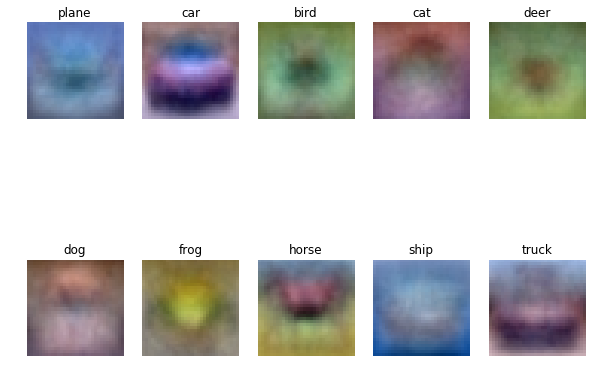

In [81]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])